In [1]:
import os
from os import path
import pandas as pd
import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import sklearn.model_selection as sk

In [5]:
round(4.49)

4

In [2]:
def getNormed(this_array, this_min = 0, this_max = 255, set_to_int = True):
    new_var = this_array.copy()
    rat = (this_max - this_min)/(new_var.max() - new_var.min())
    new_var = new_var * rat
    new_var -= new_var.min()
    new_var += this_min
    if set_to_int:
        return new_var.astype('uint8')
    return new_var

In [3]:
class EvaluateEpochEnd(tf.keras.callbacks.Callback):
    
    def __init__(self, test_data):
        self.test_data = test_data
        self.acc_scores_lst = []
        self.loss_scores_lst = []

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.test_data
        scores = self.model.evaluate(x, y, verbose=False)
        print('\nTesting loss: {}, accuracy: {}\n'.format(scores[0], scores[1]))
        self.acc_scores_lst.append(scores[1])
        self.loss_scores_lst.append(scores[0])

In [4]:
train = pd.read_csv('/Users/amalalmansour/Desktop/New_Images/Malignancy/machine_ratings/train.csv')
#train = pd.read_csv('/Users/amalalmansour/Desktop/New_Images/Spiculation/train.csv')
len(train)

342

In [5]:
test = pd.read_csv('/Users/amalalmansour/Desktop/New_Images/Malignancy/machine_ratings/test.csv')
#test = pd.read_csv('/Users/amalalmansour/Desktop/New_Images/Spiculation/test.csv')
len(test)

85

In [6]:
train_nodIds = train['noduleID']
test_nodIds = test['noduleID']

In [7]:
train_nodIds = np.array(train_nodIds)
test_nodIds = np.array(test_nodIds)

In [8]:
#train_labels = train["Binary_Rating_Spic"]
#train_labels = train["Binary_Rating_Mal"]
#train_ids = train['InstanceID']
#train_images = train.drop(['InstanceID', 'Binary_Rating_Spic'],  axis=1)

In [9]:
#test_labels = test["Binary_Rating_Spic"]
#test_labels = test["Binary_Rating_Mal"]
#test_ids = test['InstanceID']
#test_images = test.drop(['InstanceID', 'Binary_Rating_Spic'],  axis=1)

In [10]:
#x_train, x_val, y_train, y_val = sk.train_test_split(x_train,y_train,test_size=0.2, random_state = 42, shuffle=True)

In [11]:
# collect all images for training
image_folder = '/Users/amalalmansour/Desktop/images_1332'
train_images = []
test_images = []
train_noduleId = []
test_noduleId = []
print(image_folder)

for dir1 in os.listdir(image_folder):
    print(dir1)
    if not dir1.startswith('.'):
        for file in os.listdir(os.path.join(image_folder, dir1)):
            #print(file)
            noduleID = file.split('.')[0]
            if not file.startswith('.'):
                noduleID = int(noduleID)
                if noduleID in train_nodIds:
                    train_noduleId.append(noduleID)
                    temp_image = np.loadtxt(os.path.join(image_folder, dir1,file))
                    temp_image = getNormed(temp_image)
                    #enlarged_img = getSamePadding(temp_image)
                    train_images.append(temp_image)
            
                if noduleID in test_nodIds:
                    test_noduleId.append(noduleID)
                    temp_image = np.loadtxt(os.path.join(image_folder, dir1,file))
                    temp_image = getNormed(temp_image)
                    #enlarged_img = getSamePadding(temp_image)
                    test_images.append(temp_image)

/Users/amalalmansour/Desktop/images_1332
.DS_Store
Malignancy_2
Malignancy_5
Malignancy_4
Malignancy_3
Malignancy_1


In [12]:
tr_df = pd.DataFrame(train_noduleId,columns =['noduleID'])
print(tr_df)

     noduleID
0        2412
1         471
2        1496
3        2210
4        2666
..        ...
337       642
338       643
339       657
340       904
341      2219

[342 rows x 1 columns]


In [13]:
te_df = pd.DataFrame(test_noduleId,columns =['noduleID'])
print(te_df)

    noduleID
0       1437
1        951
2        791
3        595
4       2252
..       ...
80      2218
81        25
82       440
83      2609
84       290

[85 rows x 1 columns]


In [14]:
#df = pd.read_csv("/Users/amalalmansour/Desktop/New_Images/LIDC_LabelANDRating.csv")
df = pd.read_csv("/Users/amalalmansour/Desktop/New_Images/Malignancy/machine_ratings/machine_mal_ratings.csv")
display(df)

,InstanceID,noduleID,Agglomeration,Binary Rating,m1,m2,m3,m4,machine_Agreement,Agreement
0,4,1,NaN,3,5.0,5.0,4.0,4.0,Low Radiologists Agreement,1
1,118,5,NaN,3,4.0,4.0,3.0,2.0,Low Radiologists Agreement,1
2,134,3,NaN,3,5.0,5.0,4.0,4.0,Low Radiologists Agreement,1
3,143,4,NaN,3,4.0,4.0,3.0,2.0,Low Radiologists Agreement,1
4,175,6,NaN,3,2.0,1.0,1.0,2.0,Low Radiologists Agreement,1
...,...,...,...,...,...,...,...,...,...,...
1327,40771,2655,NaN,3,NaN,2.0,3.0,2.0,Low Radiologists Agreement,1
1328,40780,2657,NaN,3,3.0,5.0,4.0,5.0,Low Radiologists Agreement,1
1329,40794,2656,5.0,1,2.0,5.0,5.0,5.0,High Radiologists Agreement,2
1330,40801,2658,NaN,3,4.0,3.0,4.0,3.0,Low Radiologists Agreement,1


In [15]:
train_slices = pd.merge(tr_df, df)
display(train_slices)

,noduleID,InstanceID,Agglomeration,Binary Rating,m1,m2,m3,m4,machine_Agreement,Agreement
0,2412,36785,2.0,0,2.0,2.0,4.0,2.0,High Radiologists Agreement,2
1,471,6853,3.0,2,3.0,3.0,3.0,2.0,High Radiologists Agreement,2
2,1496,22427,2.0,0,2.0,3.0,2.0,2.0,High Radiologists Agreement,2
3,2210,33628,2.0,0,2.0,2.0,2.0,2.0,Full Radiologists Agreement,3
4,2666,1903,2.0,0,2.0,2.0,NaN,2.0,High Radiologists Agreement,2
...,...,...,...,...,...,...,...,...,...,...
337,642,9234,1.0,0,1.0,1.0,1.0,2.0,High Radiologists Agreement,2
338,643,9251,1.0,0,1.0,1.0,1.0,1.0,Full Radiologists Agreement,3
339,657,9498,3.0,2,3.0,1.0,3.0,3.0,High Radiologists Agreement,2
340,904,13301,1.0,0,1.0,1.0,NaN,1.0,High Radiologists Agreement,2


In [16]:
test_slices = pd.merge(te_df, df)
display(test_slices)

,noduleID,InstanceID,Agglomeration,Binary Rating,m1,m2,m3,m4,machine_Agreement,Agreement
0,1437,21649,2.0,0,2.0,2.0,4.0,2.0,High Radiologists Agreement,2
1,951,13946,2.0,0,2.0,2.0,2.0,NaN,High Radiologists Agreement,2
2,791,11293,2.0,0,2.0,NaN,2.0,2.0,High Radiologists Agreement,2
3,595,8511,2.0,0,2.0,2.0,2.0,3.0,High Radiologists Agreement,2
4,2252,34485,2.0,0,2.0,2.0,2.0,NaN,High Radiologists Agreement,2
...,...,...,...,...,...,...,...,...,...,...
80,2218,33830,1.0,0,1.0,1.0,1.0,1.0,Full Radiologists Agreement,3
81,25,360,1.0,0,1.0,1.0,1.0,1.0,Full Radiologists Agreement,3
82,440,6517,1.0,0,1.0,1.0,1.0,1.0,Full Radiologists Agreement,3
83,2609,39936,1.0,0,1.0,1.0,1.0,3.0,High Radiologists Agreement,2


In [17]:
#train_ids = train_slices["Binary_Rating_Spic"]
#train_ids = train_slices["Binary_Rating_Mal"]
#test_ids = test_slices["Binary_Rating_Spic"]
#test_ids = test_slices["Binary_Rating_Mal"]
train_ids = train_slices["Binary Rating"]
test_ids = test_slices["Binary Rating"]

In [18]:
print(train_ids.value_counts())
print(test_ids.value_counts())

2    171
0    124
1     47
Name: Binary Rating, dtype: int64
0    38
2    37
1    10
Name: Binary Rating, dtype: int64


In [19]:
train_images = np.array(train_images)
print(len(train_images))
test_images = np.array(test_images)
print(len(test_images))

342
85


In [20]:
#x_train, x_val, y_train, y_val = sk.train_test_split(train_images,train_ids,test_size=0.2, shuffle=True)

In [21]:
# Reshape the data so the pixel vectors turn into arrays, and so the instance id's are also arrays
train_data = train_images.reshape(train_images.shape[0],71,71,1)  
train_ids = np.array(train_ids)
#val_data = x_val.reshape(x_val.shape[0],71,71,1)  
#val_ids = np.array(y_val)
test_data = test_images.reshape(test_images.shape[0], 71, 71,1)
test_ids = np.array(test_ids)

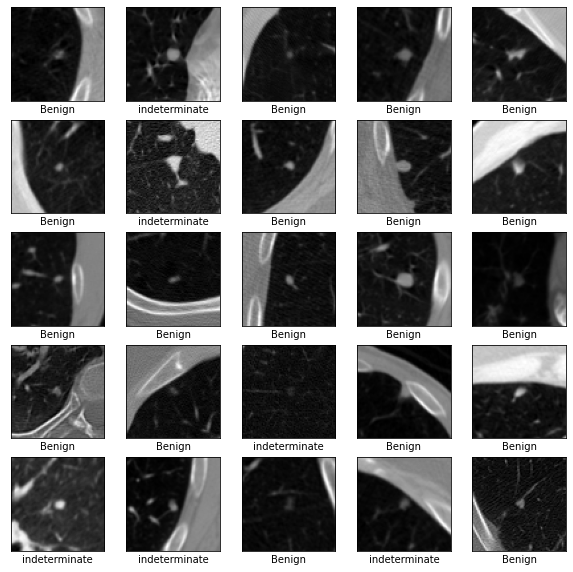

In [22]:
class_names=['Benign','Malignant','indeterminate']
#class_names=['Unspiculated','Spiculated']
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_data[i],'gray')
    plt.xlabel(class_names[train_ids[i]])
plt.show()

In [23]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(71, 71, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 69, 69, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 34, 34, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        36928     
                                                                 
Total params: 55,744
Trainable params: 55,744
Non-traina

In [25]:
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
#model.add(layers.Dense(2,activation='softmax')) # Spiculation
model.add(layers.Dense(3,activation='softmax')) # Malignancy

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 69, 69, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 34, 34, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 12544)             0

In [27]:
# Compile the model
model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

#history = model.fit(train_data, train_ids, epochs=50, validation_data=(test_data, test_ids))
#test_accuracy = EvaluateEpochEnd((test_data,  test_ids))
history = model.fit(train_data, train_ids, epochs=50
                    , validation_data=(test_data, test_ids))
                    #, callbacks=[test_accuracy])

Epoch 1/50
11/11 [==============================] - 1s 36ms/step - loss: 63.5059 - accuracy: 0.4503 - val_loss: 0.8471 - val_accuracy: 0.5882
Epoch 2/50
11/11 [==============================] - 0s 15ms/step - loss: 0.7056 - accuracy: 0.7076 - val_loss: 0.7327 - val_accuracy: 0.7059
Epoch 3/50
11/11 [==============================] - 0s 15ms/step - loss: 0.4617 - accuracy: 0.8509 - val_loss: 1.0070 - val_accuracy: 0.6235
Epoch 4/50
11/11 [==============================] - 0s 16ms/step - loss: 0.2428 - accuracy: 0.9298 - val_loss: 1.4398 - val_accuracy: 0.6941
Epoch 5/50
11/11 [==============================] - 0s 17ms/step - loss: 0.1739 - accuracy: 0.9415 - val_loss: 1.2110 - val_accuracy: 0.6941
Epoch 6/50
11/11 [==============================] - 0s 17ms/step - loss: 0.0687 - accuracy: 0.9766 - val_loss: 1.9832 - val_accuracy: 0.7176
Epoch 7/50
11/11 [==============================] - 0s 16ms/step - loss: 0.0462 - accuracy: 0.9854 - val_loss: 1.9688 - val_accuracy: 0.6941
Epoch 8/50
1

In [28]:
model.save("/Users/amalalmansour/Desktop/New_Images/Malignancy/CNN/CNN_machine_model")

INFO:tensorflow:Assets written to: /Users/amalalmansour/Desktop/New_Images/Malignancy/CNN/CNN_machine_model/assets


In [29]:
#test_acc = test_accuracy.acc_scores_lst
#test_loss = test_accuracy.loss_scores_lst

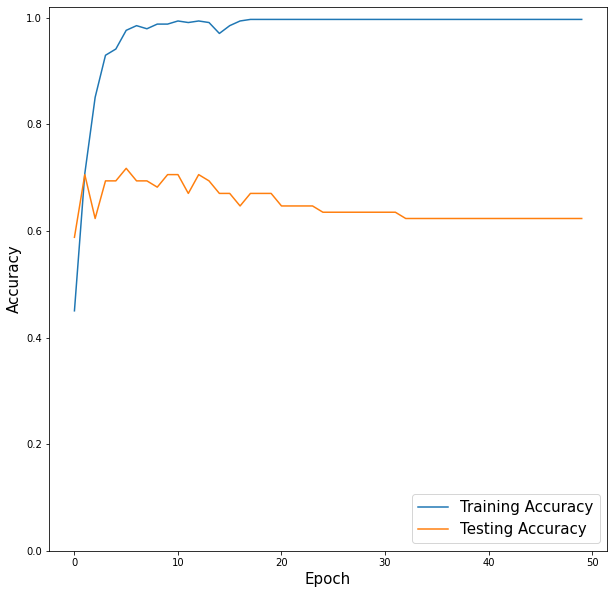

In [30]:
plt.figure(figsize=(10, 10))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Testing Accuracy')
#plt.plot(test_acc, label = 'Testing Accuracy')
plt.xlabel('Epoch', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)
plt.ylim([0.0, 1.02])
plt.legend(loc='lower right', prop={'size': 15})

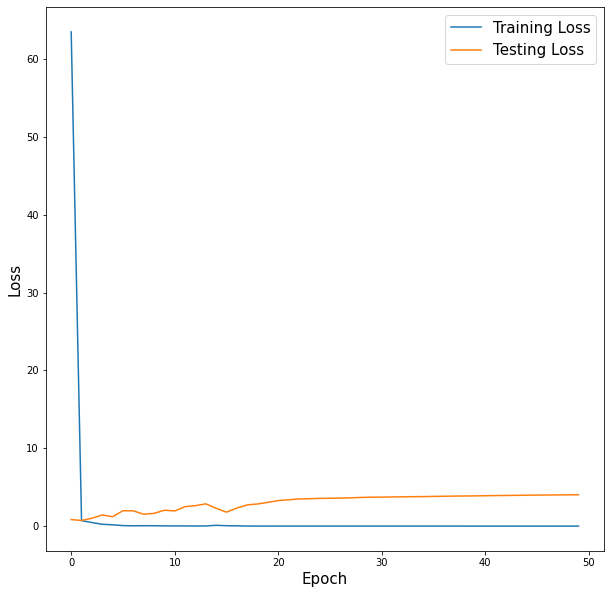

In [31]:
plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label = 'Testing Loss')
#plt.plot(test_loss, label = 'Testing Loss')
plt.xlabel('Epoch',  fontsize = 15)
plt.ylabel('Loss',  fontsize = 15)
#plt.ylim([0.0, 1.02])
plt.legend(loc='upper right', prop={'size': 15})

In [32]:
test_loss, test_acc = model.evaluate(test_data,  test_ids, verbose=2)

3/3 - 0s - loss: 4.0367 - accuracy: 0.6235 - 36ms/epoch - 12ms/step


In [33]:
predictions = model.predict(test_data)
y_preds_multiclass = predictions.argmax(axis=1)
y_preds_multiclass

array([2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 0, 2, 2,
       0, 2, 2, 0, 0, 2, 2, 2, 0, 0, 2, 1, 2, 2, 1, 2, 0, 2, 0, 2, 2, 2,
       2, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2,
       2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0])

In [34]:
tr_predictions = model.predict(train_data)
y_tr_preds_multiclass = tr_predictions.argmax(axis=1)
y_tr_preds_multiclass

array([0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2,
       0, 2, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1,
       1, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0,
       2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [35]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(test_ids, y_preds_multiclass))

[[19  1 18]
 [ 1  5  4]
 [ 6  2 29]]


In [36]:
print(confusion_matrix(train_ids, y_tr_preds_multiclass))

[[124   0   0]
 [  0  46   1]
 [  0   0 171]]


In [37]:
#model = keras.models.load_model("/Users/amalalmansour/Desktop/New_Images/Spiculation/CNN/CNN_model_All" , compile = True)

In [38]:
#test_loss, test_acc = model.evaluate(test_data,  test_ids, verbose=2)